In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from scipy import ndimage

In [6]:
def initU(x,y,c):
    U=np.random.rand(x,y,c)
    rsum=U.sum(axis=2)
    NU = np.divide(U,rsum[:,:, None])
    return NU

def dist_matf(data,cen,c):
    eps=0.001
    x,y = data.shape
    c = cen.shape[0]
    data1 =  np.repeat(data[:, :, None], repeats = c, axis=2)
    dist = np.zeros((x,y,c))
    repetitions = x*y
    repeats_Cen = np.tile(cen, (repetitions, 1))
    repeats_Cen = np.reshape(repeats_Cen,(x,y,c))
    dist = (data1-repeats_Cen)**2
    return dist+eps
# returns distance matrix mean
def dist_mean_filter(dist_mat,window_size,c):
    new_data=[]
    kernel=np.ones((ws,ws),dtype=np.float32)
    kernel=kernel/(ws*ws)
    # 1 / 9
    for i in range(c):
        num=dist_mat[:,:,i]
        temp=ndimage.convolve(num,kernel,mode='constant',cval=0.0)
        new_data.append(temp)
    mean_dist=np.stack(new_data,axis=2)
    return mean_dist
# returns mean neighbourhood values for updateV
def mean_data(data,ws):
    kernel=np.ones((ws,ws),dtype=np.float32)
    kernel=kernel/(ws*ws)
    mean_data=ndimage.convolve(data,kernel, mode='constant', cval=0.0)
    return mean_data


def updateU(dist_mat,distmean,m,alpha,c):
    # dist_mat=dist_matf(data,cen,c)
    # mean_dist=dist_mean_filter(dist_mat,ws,c)
    num=(dist_mat+ alpha*distmean)**(-1/(m-1))
    # sum over all centroids
    denom=num.sum(axis=2)
    updatedU=num/denom[:,:,None]
    return updatedU

def updateV(data,meandata,mf,alpha):
    data = np.repeat(data[:,:,None], repeats = c, axis=2) #(XxYxc)
    datamean = np.repeat(meandata[:,:,None], repeats = c, axis=2) #(XxYxc)
    mf_sum=mf.sum(axis=1) #(Xxc)
    mf_sum=mf_sum.sum(axis=0) #(1xc)
    denom=mf_sum*(1+alpha) #(1xc)
    new_data=data+(datamean*alpha) #(XxYxc)
    MulUD = np.multiply(mf,new_data) #(XxYxc)
    MulUD_sum=MulUD.sum(axis=1)
    num=MulUD_sum.sum(axis=0)
    cen=np.divide(num,denom) #(1xc)
    cen=cen.transpose()
    return cen

def obj_function(mf,dist_mat,term):
    obj=mf*dist_mat
    term=mf*term
    obj=obj+term
    objfunctionval=obj.sum(axis=2)
    objfunctionval=obj.sum(axis=1)
    objfunctionval=obj.sum()
    return objfunctionval
def FCM_S1(data,ws,alpha,m,c,epochs):
    x,y=data.shape
    Uinit=initU(x,y,c)
    U=Uinit
    meandata=mean_data(data,ws)
    obj=[]
    olddiff=0.0
    for i in range(epochs):
        mf=U**(m)
        cen=updateV(data,meandata,mf,alpha)
        # print(cen.shape)
        dist_mat = dist_matf(data,cen,c)
        distmean = dist_mean_filter(dist_mat,ws,c)
        
        UNew=updateU(dist_mat,distmean,m,alpha,c)
        objval=obj_function(mf,dist_mat,alpha*distmean)
        obj.append(objval)
        diff=((np.absolute(U-UNew)).sum(axis=1)).sum()
        print("Itteration ", i, "Differnce", diff)
        if (np.absolute(olddiff-diff)<0.01):
          break
        olddiff = diff
        U = UNew
    return U, cen, obj, dist_mat

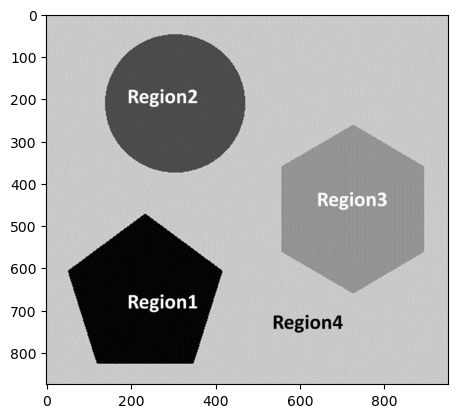

In [33]:
import matplotlib.pyplot as plt 
import matplotlib.image as img 
# testimage=img.imread('photoshop_created_image5.png')
testimage=img.imread('NewImg2_sir.jpg')
testimage2=img.imread('brain_mri.jpeg')
plt.imshow(testimage,cmap='gray')
plt.show()

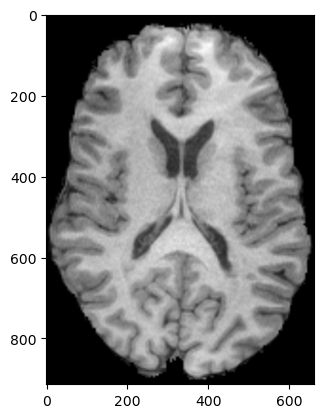

In [21]:
plt.imshow(testimage2,cmap='gray')
plt.show()

In [8]:
print(testimage.shape)

(875, 950)


In [22]:
# to convert to grayscale
import cv2
img_gray = cv2.cvtColor(testimage2, cv2.COLOR_BGR2GRAY)
cv2.imshow('Grayscale Image', img_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
print(testimage.shape)

(875, 950)


In [34]:
data=testimage
m=2
epochs=100
ws=3
alpha=0.01
c=4
U,Cen,OBJ,Dist_Mat=FCM_S1(data,ws,alpha,m,c,epochs)

Itteration  0 Differnce 375736.61640331126
Itteration  1 Differnce 6637.830058421496
Itteration  2 Differnce 26358.9567944557
Itteration  3 Differnce 100600.40237019213
Itteration  4 Differnce 318868.4727465829
Itteration  5 Differnce 582612.6525385112
Itteration  6 Differnce 378699.66516707104
Itteration  7 Differnce 106992.35968590683
Itteration  8 Differnce 91766.06540918958
Itteration  9 Differnce 12317.55936279166
Itteration  10 Differnce 571.3583289496777
Itteration  11 Differnce 37.78285168348008
Itteration  12 Differnce 2.7524987472210203
Itteration  13 Differnce 0.20291011683838311
Itteration  14 Differnce 0.015111971974397499
Itteration  15 Differnce 0.001137008612862398
Itteration  16 Differnce 8.627512851630168e-05


In [35]:
Umax = (U == U.max(axis=2)[:,:,None]).astype(float)
print(Umax.shape)
seg1 = Umax[:,:,0]
# seg1 = np.reshape(seg1,img_gray.shape)
seg2 = Umax[:,:,1]
# seg2 = np.reshape(seg2,img_gray.shape)
seg3 = Umax[:,:,2]
# seg3 = np.reshape(seg3,img_gray.shape)
seg4 = Umax[:,:,3]
# seg4 = np.reshape(seg4,img_gray.shape)

(875, 950, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Clusters after FCM_S')

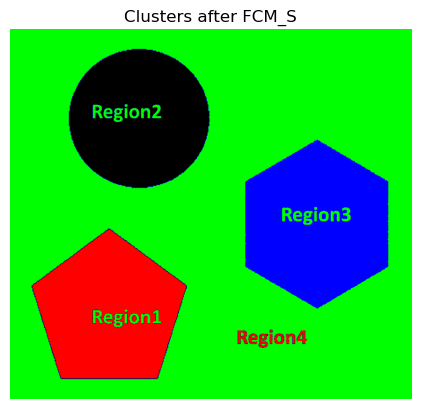

In [36]:
cmb=np.dstack((seg1,seg2*2,seg3*3))
plt.imshow(cmb,cmap='gray')
plt.axis('off')
plt.title('Clusters after FCM_S')

In [38]:
seg1,seg2,seg3,seg4=sorted([seg1,seg2,seg3,seg4],key=lambda m: np.mean(m))

[]

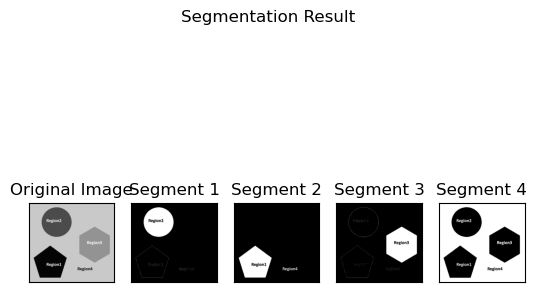

In [39]:
fig, axs = plt.subplots(1,5)
fig.suptitle('Segmentation Result')
axs[0].imshow(testimage,'gray')
axs[0].set_title('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(seg1,'gray')
axs[1].set_title('Segment 1')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow(seg2,'gray')
axs[2].set_title('Segment 2')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(seg3,'gray')
axs[3].set_title('Segment 3')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[4].imshow(seg4,'gray')
axs[4].set_title('Segment 4')
axs[4].set_xticks([])
axs[4].set_yticks([])

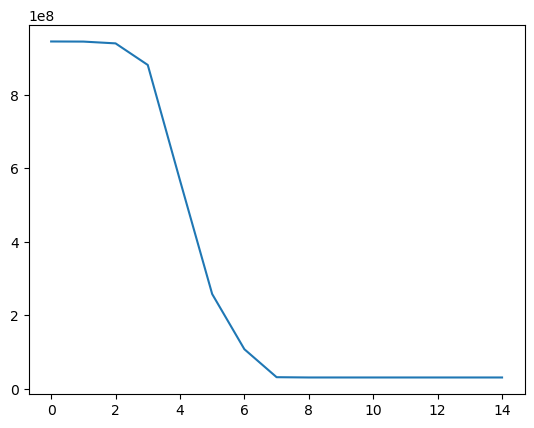

In [17]:
def Plot(obj):
  y = obj
  y.pop(0)
  x = list(range(0,len(obj)))
  return plt.plot(x, y)
Plot(OBJ)

In [40]:
data=img_gray
m=2
epochs=100
ws=3
alpha=0.05
c=4
U,Cen,OBJ,Dist_Mat=FCM_S1(data,ws,alpha,m,c,epochs)

Itteration  0 Differnce 273746.66890468076
Itteration  1 Differnce 14202.467932806612
Itteration  2 Differnce 48688.08138831738
Itteration  3 Differnce 131986.867212647
Itteration  4 Differnce 248193.88687314896
Itteration  5 Differnce 318045.8798479899
Itteration  6 Differnce 267236.00909274985
Itteration  7 Differnce 151096.37877077432
Itteration  8 Differnce 75000.25909886538
Itteration  9 Differnce 30375.59192096347
Itteration  10 Differnce 16438.676477608675
Itteration  11 Differnce 12995.902771724897
Itteration  12 Differnce 11141.0051223673
Itteration  13 Differnce 9601.876041423597
Itteration  14 Differnce 8263.385344050901
Itteration  15 Differnce 7103.493306240269
Itteration  16 Differnce 6104.005643496299
Itteration  17 Differnce 5240.897927718384
Itteration  18 Differnce 4496.1873668391645
Itteration  19 Differnce 3854.9173859469147
Itteration  20 Differnce 3302.004060457665
Itteration  21 Differnce 2826.396019327627
Itteration  22 Differnce 2417.826621097031
Itteration  23

In [41]:
Umax = (U == U.max(axis=2)[:,:,None]).astype(float)
print(Umax.shape)
seg1 = Umax[:,:,0]
# seg1 = np.reshape(seg1,img_gray.shape)
seg2 = Umax[:,:,1]
# seg2 = np.reshape(seg2,img_gray.shape)
seg3 = Umax[:,:,2]
# seg3 = np.reshape(seg3,img_gray.shape)
seg4 = Umax[:,:,3]
# seg4 = np.reshape(seg4,img_gray.shape)

(914, 662, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Clusters after FCM_S')

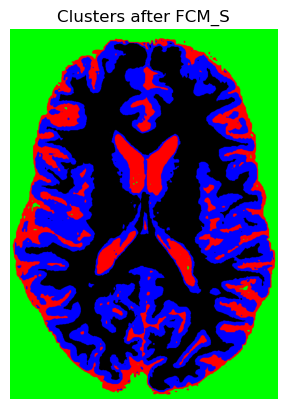

In [42]:
cmb=np.dstack((seg1,seg2*2,seg3*3))
plt.imshow(cmb,cmap='gray')
plt.axis('off')
plt.title('Clusters after FCM_S')

In [43]:
seg1,seg2,seg3,seg4=sorted([seg1,seg2,seg3,seg4],key=lambda m: np.mean(m))

[]

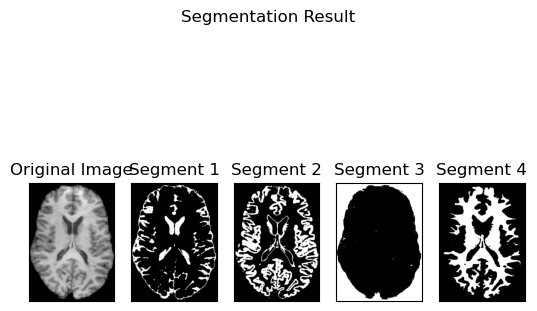

In [44]:
fig, axs = plt.subplots(1,5)
fig.suptitle('Segmentation Result')
axs[0].imshow(testimage2,'gray')
axs[0].set_title('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(seg1,'gray')
axs[1].set_title('Segment 1')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow(seg2,'gray')
axs[2].set_title('Segment 2')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(seg3,'gray')
axs[3].set_title('Segment 3')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[4].imshow(seg4,'gray')
axs[4].set_title('Segment 4')
axs[4].set_xticks([])
axs[4].set_yticks([])

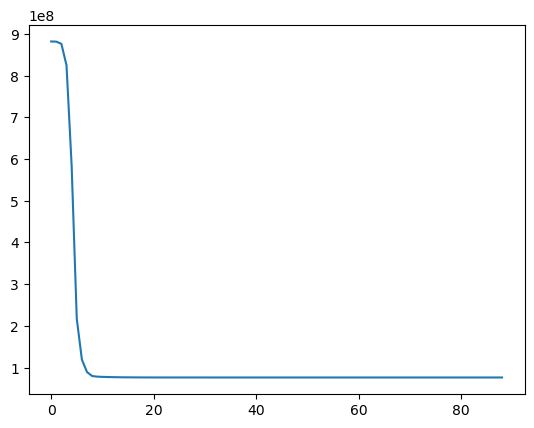

In [45]:
def Plot(obj):
  y = obj
  y.pop(0)
  x = list(range(0,len(obj)))
  return plt.plot(x, y)
Plot(OBJ)